# Recap: EDA
- 78 Video:
  - 6224 frame images
  - 6224 mask images
  - 6224 mask enhance images
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
!pip install watermark

  Obtaining dependency information for watermark from https://files.pythonhosted.org/packages/67/ee/32fec350c20ff060064d058c37df53dd1fad74dfea9532faf2868b0512b5/watermark-2.4.3-py2.py3-none-any.whl.metadata


In [2]:
%load_ext watermark
%watermark -v -p pandas,numpy,matplotlib,seaborn,torch,torchvision,PIL,cv2,tensorboard

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

pandas     : 2.1.4
numpy      : 1.24.3
matplotlib : 3.7.4
seaborn    : 0.12.2
torch      : 2.0.0
torchvision: 0.15.1
PIL        : 9.5.0
cv2        : 4.8.1
tensorboard: 2.13.0



In [3]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2

from tqdm.auto import tqdm

To ensure the reproducibility, we will control the seed of random generators

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Prepare dataset

In [5]:
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head/dataset'
os.listdir(dataset_path)

['enhance_mask', 'frame_label.csv', 'mask', 'image']

In [6]:
img_paths = os.listdir(f'{dataset_path}/image')
mask_paths = os.listdir(f'{dataset_path}/mask')

print(f'{len(img_paths)} frame images')
print(f'{len(mask_paths)} mask images')

6224 frame images
6224 mask images


In [7]:
# Mapping 1-1 between mask and image
imgs = [img.replace("_mask", "") for img in mask_paths]

# Define dataset
- load images and masks, apply transformations, and return them as a dictionary

In [8]:
print(len(imgs))
print(len(mask_paths))

6224
6224


In [9]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_mask, test_mask = train_test_split(imgs, mask_paths, test_size = 0.1, random_state=123)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1, random_state=123)

In [10]:
print(len(train_img))
print(len(test_img))
print(len(val_img))

5040
623
561


#### Define dataset class

In [11]:
path = f'{dataset_path}/mask/{train_mask[1]}'
# Image.open(path)

In [12]:
# define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{dataset_path}/image/{img_name}'
        image = Image.open(img_path)

        mask_name = self.masks[idx]
        mask_path = f'{dataset_path}/mask/{mask_name}'
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to appropriate format (e.g., LongTensor for binary segmentation)
        # mask = torch.as_tensor(mask, dtype=torch.long)

        return image, mask

In [13]:
img_size = 1024
re_size = 128
transform = transforms.Compose([
    transforms.CenterCrop((img_size, img_size)),
    transforms.Resize(size=(re_size, re_size)),
    transforms.ToTensor(),
])

#### Define dataset instance

In [14]:
train = SegmentationDataset(train_img, train_mask, transform=transform)
val = SegmentationDataset(val_img, val_mask, transform=transform)
test = SegmentationDataset(test_img, test_mask, transform=transform)

In [15]:
train[0]

(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

#### Instantiate dataloaders

In [16]:
batch_size = 32

train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    dataset=val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)


#### Test dataloaders

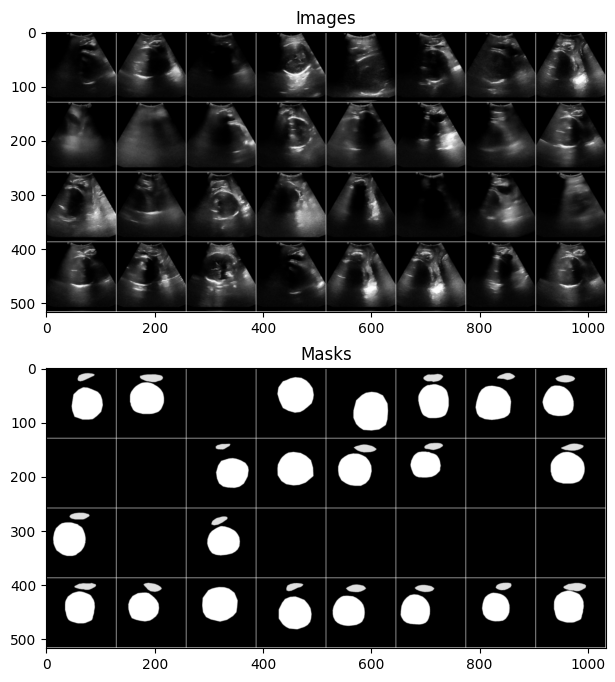

In [17]:
%matplotlib inline
images, masks = next(iter(train_loader))

grid_image = torchvision.utils.make_grid(
    images[:batch_size],
    padding=1,
    pad_value=1.0,
    normalize=True
)
grid_image = np.transpose(grid_image, (1, 2, 0))

grid_mask = torchvision.utils.make_grid(
    masks[:batch_size],
    padding=1,
    pad_value=1.0,
    normalize=True
)
# Transpose the dimensions for Matplotlib compatibility
grid_mask = np.transpose(grid_mask, (1, 2, 0))

# Display the images and masks side by side
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

axes[0].imshow(grid_image)
axes[0].set_title('Images')

axes[1].imshow(grid_mask)
axes[1].set_title('Masks')

plt.show()

In [18]:
# def visualize_pairs(images, masks, batch_size):
#     fig, axes = plt.subplots(2, int(batch_size/2), figsize=(2*batch_size, batch_size))

#     for i in range(batch_size):
#         # Convert PyTorch tensors to NumPy arrays
#         image_np = images[i].squeeze().numpy()
#         mask_np = masks[i].squeeze().numpy()

#         # Compute the row and column indices for the subplot
#         row_index = i // 4
#         col_index = i % 4

#         # Display the image and mask in the grid
#         axes[row_index, col_index].imshow(image_np, cmap='gray')
#         axes[row_index, col_index].imshow(mask_np, cmap='viridis', alpha=0.5)
#         axes[row_index, col_index].set_title(f'Pair {i + 1}')

#     # Adjust layout for better visualization
#     plt.tight_layout()
#     plt.show()

# images, masks = next(iter(train_loader))
# visualize_pairs(images, masks, batch_size)

# Baseline model

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Encoder with downsampling layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Preserve spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # ... add more layers as needed
        )

        # Bottleneck layer for feature extraction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder with upsampling layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),  # Final output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

# Example usage
model = SegmentationModel(num_classes=1)
# input_image = torch.randn(1, 1, 1024, 1024)
# output = model(input_image)
# print(output.shape)  # Output: torch.Size([1, 10, 1024, 1024])


# Loss and optimizer

In [20]:
def dice_loss(input, target, smooth=1.0):
  # input and target should be one-hot encoded tensors
  intersection = (input * target).sum(-1)
  union = (input * input).sum(-1) + (target * target).sum(-1)
  dice = (2 * intersection + smooth) / (union + smooth)
  return 1 - dice.mean()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training

Epoch 1/5:   0%|          | 0/158 [00:00<?, ?batch/s]

Epoch 1/5, Loss: 0.015467712773552423
Validation Loss: 0.01498760117424859


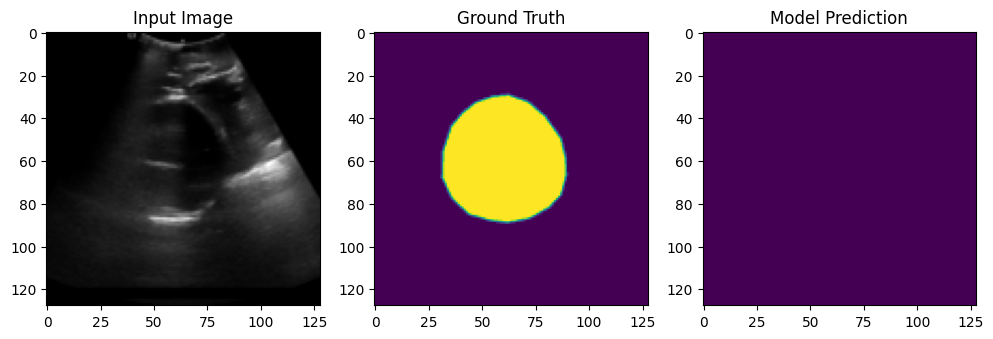

Epoch 2/5:   0%|          | 0/158 [00:00<?, ?batch/s]

Epoch 2/5, Loss: 0.014510332029077071
Validation Loss: 0.01472699311044481


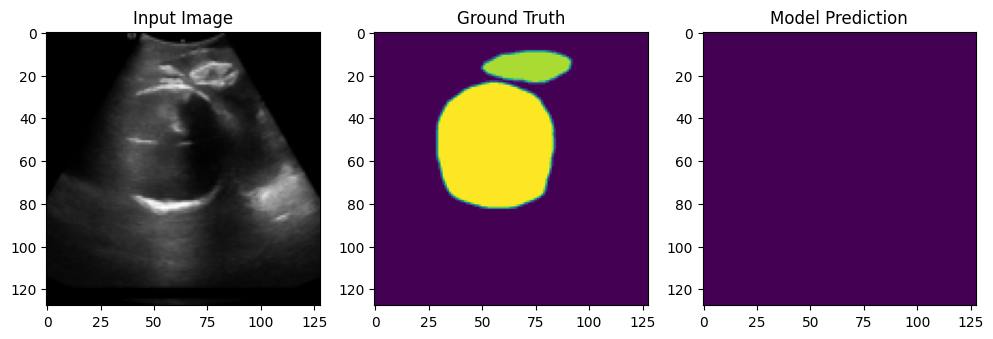

Epoch 3/5:   0%|          | 0/158 [00:00<?, ?batch/s]

Epoch 3/5, Loss: 0.014375458412532564
Validation Loss: 0.014640874332851835


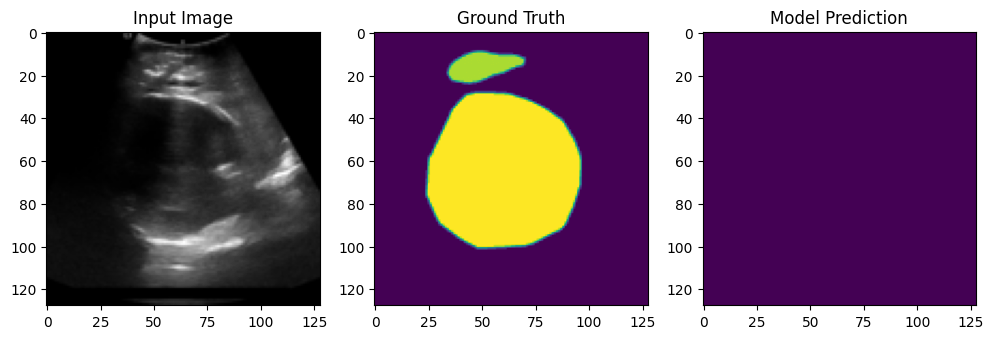

Epoch 4/5:   0%|          | 0/158 [00:00<?, ?batch/s]

Epoch 4/5, Loss: 0.014309589244142364
Validation Loss: 0.014598406023449369


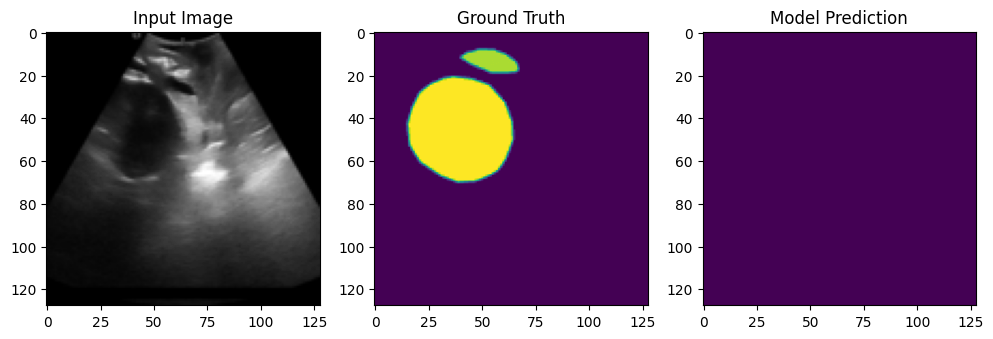

Epoch 5/5:   0%|          | 0/158 [00:00<?, ?batch/s]

Epoch 5/5, Loss: 0.01425887851775447
Validation Loss: 0.014483220047420926


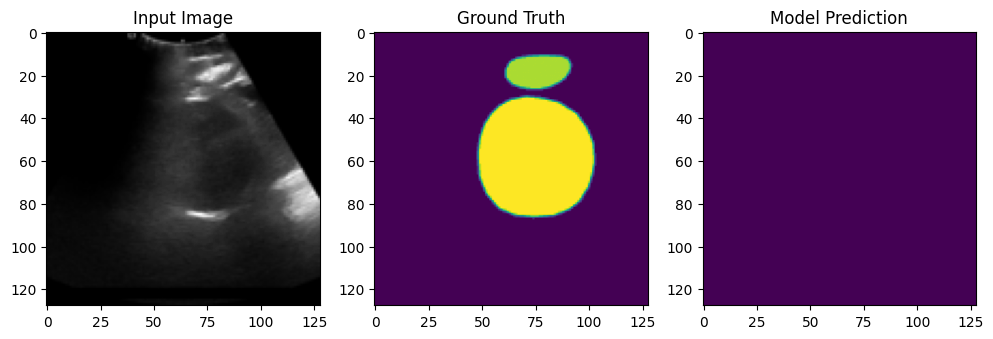

In [21]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dice_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix(loss=running_loss / (pbar.n + 1), refresh=True)
            pbar.update()

    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = dice_loss(outputs, labels)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {average_val_loss}")

    # Visualization (optional)
    # Plot some example predictions during training
    model.eval()
    with torch.no_grad():
        example_inputs, example_labels = next(iter(val_loader))
        example_inputs, example_labels = example_inputs.to(device), example_labels.to(device)
        example_outputs = model(example_inputs)

        # Visualize input, ground truth, and prediction
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(example_inputs[0, 0].cpu().numpy(), cmap='gray')
        plt.title('Input Image')
        plt.subplot(1, 3, 2)
        plt.imshow(example_labels[0, 0].cpu().numpy(), cmap='viridis')
        plt.title('Ground Truth')
        plt.subplot(1, 3, 3)
        plt.imshow(torch.argmax(example_outputs[0], dim=0).cpu().numpy(), cmap='viridis')
        plt.title('Model Prediction')
        plt.show()


In [22]:
# Test
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = dice_loss(outputs, labels)
        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {average_test_loss}")


Test Loss: 0.014423441886901856
